# Adversarial Robustness Toolbox (ART) and scikit-learn Pipeline

This notebook contains an example of generating adversarial samples using a black-box attack against a scikit-learn pipeline consisting of principal component analysis (PCA) and a support vector machine classifier (SVC), but any other valid pipeline would work too. The pipeline is first optimised using grid search with cross validation. The adversarial samples are created with black-box `HopSkipJump` attack. The training data is MNIST, because of its intuitive visualisation, but any other dataset including tabular data would be suitable too.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from art.utils import load_dataset
from art.estimators.classification import SklearnClassifier
from art.attacks.evasion import HopSkipJump

import warnings
warnings.filterwarnings('ignore')

## Load the training and testing dataset

In [3]:
n_features = 28*28
(x_train, y_train), (x_test, y_test), _, _ = load_dataset('mnist')
x_train = x_train.reshape((x_train.shape[0], n_features))
x_test = x_test.reshape((x_test.shape[0], n_features))
y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)

# Select a smaller set of samples to accelerate notebook example, remove for higher accuracy
x_train = x_train[0:1000]
x_test = x_test[0:100]
y_train = y_train[0:1000]
y_test = y_test[0:100]

## Create a pipeline containing PCA and SVC classifier

In [4]:
svc = SVC(C=1.0, kernel='rbf')
pca = PCA()
pipeline = Pipeline(steps=[('pca', pca), ('svc', svc)])

## Grid search and cross validation to optimise number of PCA components and error term penalty

In [6]:
param_grid = {'pca__n_components': [5, 20, 30, 40, 50, 64],
              'svc__C': np.logspace(-4, 4, 5)}
search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5)
search.fit(x_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.909):
{'pca__n_components': 30, 'svc__C': 100.0}


## Create a black-box attack using ART

In [7]:
classifier = SklearnClassifier(model=search.best_estimator_)
attack = HopSkipJump(classifier=classifier, targeted=False, norm=np.inf, max_iter=100, max_eval=100,
                     init_eval=100, init_size=100)

## Generate adversarial samples

In [8]:
x_test_adv = attack.generate(x_test)

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

## Evaluate benign accuracy

In [9]:
accuracy_test_benign = search.score(x_test, y_test)
print('Accuracy on benign test samples {}%:'.format(accuracy_test_benign * 100))

Accuracy on benign test samples 96.0%:


## Evaluate adversarial accuracy

In [10]:
accuracy_test_adversarial = search.score(x_test_adv, y_test)
print('Accuracy on adversarial test samples {}%:'.format(accuracy_test_adversarial * 100))

Accuracy on adversarial test samples 2.0%:


## Inspect a benign test sample

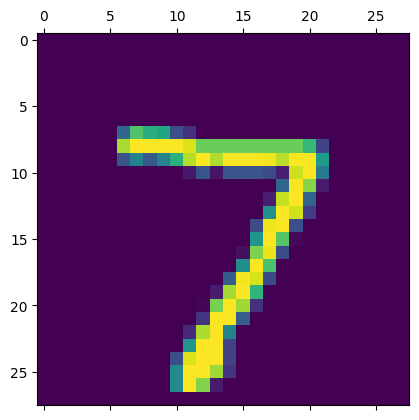

In [11]:
plt.matshow(x_test[0].reshape((28, 28)));

In [12]:
print('Predicted label:', search.predict(x_test[0:1])[0])

Predicted label: 7


## Inspect an adversarial test sample

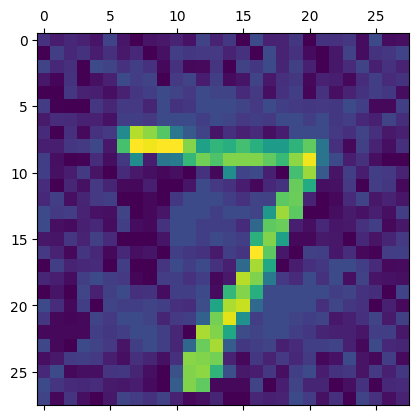

In [13]:
plt.matshow(x_test_adv[0].reshape((28, 28)));

In [14]:
print('Predicted label:', search.predict(x_test_adv[0:1])[0])

Predicted label: 3


In [15]:
print('L_Infinity-norm:', np.linalg.norm(x_test_adv[0] - x_test[0], ord=np.inf))

L_Infinity-norm: 0.22557301743357788
